# Sumo Full Simulation
## Introduction
This notebook allows you to run a full Sumo simulation, using TraCI to insert traffic and collect statistics.

## Code Overview
There are three main code cells in this notebook. The first is some data pre-processing to help generate the input parameters described below. The second is the cell that actually runs the Sumo simulation and generates traffic using the input parameters. It also collects statistics on what is happening at each of the curbs and for each vehicle journey. These results are saved to specified file paths. The last code cell creates matplotlib plots to look at how the simulation did compared to known data.

## Input Parameters
This simulation takes a couple different inputs:
* A sumocfg file that specifies what network to use
* A list of traffic volume numbers. This should be an array of integers and represent how much total incoming traffic arrives at the airport for a given hour time segment. This array can be of any length -- the simulation can run through the whole array unless you specify an early cutoff with `simHours`.
* Various lists that describe where the hourly traffic volume arrives from (North vs South), goes to (curb or pass thru) and departs to (North vs South):
    * A list of the fraction of traffic that arrives from the north. This should be a list of floats and represent how much of the incoming hourly bucket of traffic arrived via the northern toll plaza. It must be the same length list as the traffic volume numbers.
    * A list of the fraction of traffic that departs to the north. This should be a list of floats and represent how much of the hourly bucket of traffic departs the airport via the northern exit. It must be the same length list as the traffic volume numbers.
    * A list of the fraction of pass thru traffic. This should be a list of floats and represent how much of the hourly bucket of traffic were pass thru vehicles that didn't stop at a curb. It must be the same length list as the traffic volume numbers.
    * A list of the fraction of non-pass-thru-traffic that visited *each of the various curb locations*. This is a list of lists. Each sublist contains fractions (floats) that represents how much of the *non-pass-thru* (not total) traffic visited each named curb. Ordering is important here, and is kept consistent using code in traciHelper.py. Note that each sublist should sum to 1: all non-pass-thru traffic visits exactly one of the curbs.

For example, say you have a network with four curb locations, and run a simulation with the following inputs:
```python
trafficVolumes = [100, 200, 300]
fractionArrivingNorth = [0.6, 0.5, 0.6]
fractionDepartingNorth = [0.3, 0.7, 0.5]
fractionPassThru = [0.1, 0.4, 0.2]
fractionToCurbs = [[0.3, 0.5, 0.1, 0.1],
                   [0.1, 0.3, 0.4, 0.2],
                   [0.6, 0.1, 0.1, 0.2]]
```

In this example, the simulation will run for three hours because `trafficVolumes` is three elements long. The first hour will have 100 vehicles enter the airport. Of those 100 vehicles, 60% will enter the airport via the northern toll plaza, and 30% will exit via the northern exit. The simulation will assign the entry and exit points randomly with the specified distribution. Of the 100 cars that enter the airport, 10% are pass thru. The remaining 90% will visit one of the four curbs (in this example there are only four curbs -- in our actually network there are more like 19). In this first hour the distribution across curbs is 30% to curb1, 50% to curb2, 10% to curb3, and 10% to curb4. The simulation will randomly selection routes that visit the curbs with that distribution. After determining what 100 routes represent the distributions for this hour, the simulation can begin inserting vehicles. There will be 100 vehicles inserted into the simulation this hour. Rather than insert them all at the start of the hour, this code attempts to randomly scatter them evenly across the hour.

## Output Format
Running the simulation will create two output files.
### Vehicle Travel Time Results
This file is a csv. It has a header row:`Route,Scheduled,Started,Ended,DelayBeforeStart,TravelTime`. It then has a row for __each vehicle that was a part of the simulation__. The columns are as follows:
* __Route__: The name of the route that this vehicle took. Route names follow the convention defined in `traciHelper.py` and generally look like startToMiddleToEnd.
* __Scheduled__: The simulation time tick (in-simulation seconds since simulation start) that we attempted to insert this vehicle.
* __Started__: The simulation time tick (in-simulation seconds since simulation start) when the vehicle actually entered the network. If all is working well this should be only 1 tick after __Scheduled__.
* __Ended__: The simulation time tick (in-simulation seconds since simulation start) when the vehicle left the network, completing it's route.
* __DelayBeforeStart__: The difference between __Started__ and __Scheduled__. If all is going well this should always be 1. If it isn't 1 then Sumo couldn't insert a vehicle when requested: There must be some problem/congestion at the entry point.
* __TravelTime__: The difference between __Ended__ and __Started__. For a given route there will be some natural variance here due to Sumo giving vehicles varying speed and aggression parameters. But we should be able to see a trend of overall travel time increasing when the airport is experiencing congestion (or at least that's the hope!)

A sample of a results csv file:
```
South_PlazaToC_bot_2ToNorth_Exit,55.0,56.0,461.0,1.0,405.0
North_PlazaToA_top_2ToNorth_Exit,118.0,119.0,460.0,1.0,341.0
North_PlazaToD_bot_1ToSouth_Exit,121.0,122.0,562.0,1.0,440.0
South_PlazaToE_bot_1ToNorth_Exit,127.0,128.0,521.0,1.0,393.0
North_PlazaToB_top_1ToNorth_Exit,147.0,148.0,483.0,1.0,335.0
North_PlazaToE_bot_2ToSouth_Exit,148.0,149.0,659.0,1.0,510.0
North_PlazaToE_bot_2ToSouth_Exit,154.0,155.0,570.0,1.0,415.0
North_PlazaToC_bot_1ToNorth_Exit,180.0,181.0,604.0,1.0,423.0
North_PlazaToD_bot_1ToNorth_Exit,203.0,204.0,651.0,1.0,447.0
```
### Curbside Traffic Volume Results
This is a json file. It contains a description field, and then hourly count data for each of the curbs.

A sample of a results json file (truncated to only two curb locations):

```
{
"description": "Simulation of 3 hours of traffic",
"data": [{
    "A_top_1": {"hourlyCounts": [25, 5, 4] },
    "A_top_2": {"hourlyCounts": [13, 6, 2] }
    }]
```

# Data Pre-processing
Data doesn't often come to us in the nice array formats described above. Often we run the simulations based on the traffic numbers as reported by TomTom data, which are easiest to export in terms of traffic volumes over segments. The following code cell helps translate this raw data into the fractions that the simulation will use to generate traffic distributions.

In [9]:
import numpy as np
import traciHelper

# Total Traffic is directly from Toll Plaza data (via Lindy).
totalTraffic = [482.0,220.0,129.0,369.0,741.0,1077.0,1201.0,1813.0,2063.0,2432.0,2157.0,2543.0,2352.0,3059.0,2883.0,3202.0,2985.0,3422.0,2395.0,2809.0,1977.0,2116.0,1555.0,941.0,551.0,222.0,112.0,368.0,1081.0,2680.0,2272.0,2233.0,2555.0,3075.0,2469.0,2619.0,2249.0,2642.0,2379.0,2628.0,2659.0,2643.0,2252.0,2188.0,1639.0,1845.0,1304.0,996.0,513.0,200.0,129.0,335.0,906.0,1773.0,1510.0,1829.0,2095.0,2476.0,2066.0,2211.0,2163.0,2450.0,2102.0,2367.0,2218.0,2211.0,2026.0,1934.0,1495.0,1633.0,1129.0,733.0,421.0,238.0,136.0,346.0,975.0,1710.0,1339.0,1561.0,2089.0,2754.0,2084.0,2156.0,2209.0,2543.0,2308.0,2514.0,2554.0,2470.0,2156.0,1897.0,1905.0,1873.0,1462.0,1094.0,718.0,300.0,138.0,383.0,1031.0,2034.0,1569.0,1970.0,2427.0,2692.0,2314.0,2624.0,2463.0,3058.0,2842.0,3184.0,3209.0,3096.0,2751.0,2729.0,1918.0,2243.0,1520.0,1377.0,652.0,394.0,176.0,373.0,993.0,2088.0,1550.0,1863.0,2369.0,2613.0,2270.0,2617.0]
totalTraffic = [int(x) for x in totalTraffic]

# The TomTom toll plaza data comes from looking at TomTom road segments that pass through the toll plazas.
# These numbers are a volume count, and are non-whole numbers because they have been averaged across multiple segments.
tomTomTollPlazaTraffic = {
    "North": {
        "Inbound":[65.28571428571429,22.571428571428573,9,81,138.28571428571428,285.2857142857143,311.85714285714283,521.7142857142857,556.1428571428571,517.1428571428571,489.85714285714283,546.4285714285714,512.2857142857143,686.8571428571429,695.4285714285714,792.8571428571429,759.2857142857143,847.2857142857143,541.2857142857143,607.2857142857143,406.42857142857144,380,286.57142857142856,170.85714285714286,95.42857142857143,32.57142857142857,12,89,391.57142857142856,1202.2857142857142,953.2857142857143,869.8571428571429,821.8571428571429,917.7142857142857,656.1428571428571,730.1428571428571,641.2857142857143,634.7142857142857,604.7142857142857,647.7142857142857,655,625.7142857142857,468.85714285714283,506.14285714285717,355,347.14285714285717,220,161.57142857142858,97.42857142857143,24.714285714285715,18.428571428571427,67,214,705.7142857142857,632.7142857142857,633.1428571428571,607,695.1428571428571,557.2857142857143,558.8571428571429,523.4285714285714,573.4285714285714,510.42857142857144,591.5714285714286,630.8571428571429,548.7142857142857,407.85714285714283,398.57142857142856,301,308.2857142857143,196.42857142857142,117.28571428571429,78.85714285714286,28.285714285714285,13.285714285714286,65.85714285714286,251.42857142857142,641.2857142857143,502.85714285714283,629.5714285714286,635.7142857142857,784.2857142857143,488.14285714285717,555.8571428571429,613.7142857142857,385.57142857142856,508.7142857142857,674,712.7142857142857,653.7142857142857,467,397.42857142857144,370.42857142857144,347.42857142857144,268.42857142857144,158,136.42857142857142,54.142857142857146,18.571428571428573,76,285.85714285714283,658.8571428571429,506,644.4285714285714,612.7142857142857,671.5714285714286,572.2857142857143,690.2857142857143,638.4285714285714,784.1428571428571,750.7142857142857,916,881.7142857142857,861.4285714285714,635.7142857142857,586,462,421.42857142857144,345,268.14285714285717,144,86.14285714285714,30.428571428571427,85.57142857142857,271.57142857142856,719.4285714285714,491.42857142857144,668.1428571428571,676.1428571428571,758.1428571428571,552.5714285714286,641.7142857142857,718.1428571428571,759,672.5714285714286,768.2857142857143,835.7142857142857,803.4285714285714,549.2857142857143,494,426.7142857142857,421.7142857142857,293.85714285714283,217.28571428571428],
        "Outbound":[183.27272727272728,57.27272727272727,24.363636363636363,34.18181818181818,76.9090909090909,172.36363636363637,259.27272727272725,362.72727272727275,441.54545454545456,566.2727272727273,486.3636363636364,571.3636363636364,502.3636363636364,627.1818181818181,725.7272727272727,744.7272727272727,778.2727272727273,794,768.7272727272727,736.7272727272727,616.8181818181819,719.3636363636364,683.6363636363636,387.90909090909093,244.1818181818182,86.45454545454545,17.818181818181817,42.09090909090909,212.36363636363637,666,957.9090909090909,757.2727272727273,756.5454545454545,919.3636363636364,771.1818181818181,798.2727272727273,686.7272727272727,674.3636363636364,663.4545454545455,681.9090909090909,768.3636363636364,732.3636363636364,791.9090909090909,733.0909090909091,419.27272727272725,748.7272727272727,440.8181818181818,370.6363636363636,237.72727272727272,48.36363636363637,44.45454545454545,39.27272727272727,153.8181818181818,415.72727272727275,567.6363636363636,550.6363636363636,628.6363636363636,714.0909090909091,671.0909090909091,631.1818181818181,570.8181818181819,657.5454545454545,632.6363636363636,662.2727272727273,702.7272727272727,696.0909090909091,704.1818181818181,636.3636363636364,479.6363636363636,634,370.1818181818182,319.27272727272725,158.63636363636363,78.27272727272727,37.18181818181818,21.09090909090909,147.0909090909091,439.72727272727275,476.6363636363636,440.3636363636364,602.5454545454545,663.2727272727273,668.0909090909091,606.8181818181819,651.8181818181819,403,514.8181818181819,672.2727272727273,769.7272727272727,827.3636363636364,760.4545454545455,633.8181818181819,635.1818181818181,732.9090909090909,569.7272727272727,408.27272727272725,323,130.45454545454547,32.81818181818182,39.27272727272727,186,462.72727272727275,529.7272727272727,533.4545454545455,702.7272727272727,718.9090909090909,661.3636363636364,682.0909090909091,678.9090909090909,737.4545454545455,816.7272727272727,808.9090909090909,856.4545454545455,867.5454545454545,799.9090909090909,894.1818181818181,601.0909090909091,852.8181818181819,585.1818181818181,645.1818181818181,252.9090909090909,206.72727272727272,76.27272727272727,38,154.0909090909091,477.6363636363636,537,538.9090909090909,675.1818181818181,743.2727272727273,697.8181818181819,690.1818181818181,738.9090909090909,727.1818181818181,816.0909090909091,723,777.9090909090909,826.4545454545455,719.6363636363636,729.2727272727273,633.2727272727273,648.7272727272727,611.6363636363636,403.90909090909093]},
    "South":{
        "Inbound":[57.77777777777778,24,14,53.888888888888886,128.77777777777777,149.22222222222223,187.88888888888889,263.44444444444446,296.55555555555554,345.22222222222223,341.6666666666667,379.8888888888889,361.3333333333333,395.44444444444446,381.77777777777777,397.6666666666667,382.1111111111111,455.3333333333333,371.22222222222223,348.3333333333333,278,310.22222222222223,224,140.55555555555554,92.88888888888889,37.55555555555556,10.555555555555555,69,191.22222222222223,463,462.3333333333333,553.4444444444445,561,541.5555555555555,397.8888888888889,422.77777777777777,387.6666666666667,358,353.77777777777777,407.77777777777777,412,401.77777777777777,369.22222222222223,301.6666666666667,189.44444444444446,254.66666666666666,180.88888888888889,140.11111111111111,95.33333333333333,17.88888888888889,14.11111111111111,58.333333333333336,158.33333333333334,319.8888888888889,281.3333333333333,445.3333333333333,485.6666666666667,389.1111111111111,318.44444444444446,340.77777777777777,312.55555555555554,368.22222222222223,342.77777777777777,443.8888888888889,391.6666666666667,400.1111111111111,327.22222222222223,238.88888888888889,204.55555555555554,196.44444444444446,148.77777777777777,104.44444444444444,35.55555555555556,23.22222222222222,19,54.77777777777778,163.11111111111111,343.3333333333333,301.77777777777777,454.22222222222223,505.3333333333333,551.3333333333334,371.3333333333333,379.8888888888889,416.1111111111111,292.22222222222223,374,438.8888888888889,474.1111111111111,466.55555555555554,403.3333333333333,249.77777777777777,240.55555555555554,207.55555555555554,170,136.44444444444446,114.33333333333333,47.77777777777778,16,74.11111111111111,185.33333333333334,387.44444444444446,286.55555555555554,577.3333333333334,581.1111111111111,506.6666666666667,421,473.55555555555554,501.3333333333333,506.55555555555554,522.7777777777778,522.7777777777778,588.2222222222222,554.1111111111111,471,411.6666666666667,228.22222222222223,305.77777777777777,173.11111111111111,147.22222222222223,105.77777777777777,52.666666666666664,27.77777777777778,87.66666666666667,187.22222222222223,404,335.6666666666667,449.3333333333333,553.2222222222222,428.77777777777777,467.55555555555554,465.44444444444446,441,484.77777777777777,497.22222222222223,577.7777777777778,496.6666666666667,537,371.1111111111111,330.6666666666667,302.44444444444446,266.3333333333333,201.44444444444446,149.33333333333334],
        "Outbound":[81.14285714285714,30,13.428571428571429,36.285714285714285,76.14285714285714,115.57142857142857,157.71428571428572,181.85714285714286,217.57142857142858,260.7142857142857,247.85714285714286,357.7142857142857,313,313,393.14285714285717,394,397.2857142857143,411.2857142857143,438.57142857142856,401.57142857142856,261.7142857142857,313.2857142857143,314.7142857142857,154.14285714285714,131.71428571428572,62.285714285714285,22.714285714285715,25.571428571428573,96.85714285714286,249.71428571428572,359.57142857142856,225.42857142857142,368.7142857142857,373.14285714285717,295.85714285714283,373.7142857142857,339.2857142857143,321,348.85714285714283,337,442.14285714285717,421.2857142857143,403.2857142857143,297.14285714285717,195.42857142857142,285.2857142857143,236.28571428571428,147.14285714285714,100.28571428571429,37.714285714285715,20,20.857142857142858,78.71428571428571,165.28571428571428,180,202,232.57142857142858,297.57142857142856,263.57142857142856,262.42857142857144,248.71428571428572,265.57142857142856,303.7142857142857,357.2857142857143,390.7142857142857,458.14285714285717,369,254.14285714285714,208.42857142857142,230.85714285714286,173.42857142857142,134.57142857142858,81.57142857142857,45.857142857142854,12.285714285714286,22.857142857142858,86.85714285714286,181.14285714285714,203.28571428571428,244.85714285714286,308.85714285714283,352.85714285714283,303.85714285714283,262.7142857142857,311.57142857142856,282.57142857142856,326.7142857142857,406,434.14285714285717,508.85714285714283,353.7142857142857,247.71428571428572,243,216.14285714285714,202.57142857142858,137.42857142857142,168.71428571428572,63,30.714285714285715,29.571428571428573,103.28571428571429,170.57142857142858,196,224.42857142857142,295.57142857142856,321.2857142857143,312.42857142857144,375.85714285714283,380.85714285714283,415.85714285714283,451,451.7142857142857,635.5714285714286,700.8571428571429,643.7142857142857,381.14285714285717,256.14285714285717,232.85714285714286,232.71428571428572,189,97.85714285714286,62.285714285714285,40.57142857142857,40,105.85714285714286,216.85714285714286,230.14285714285714,215.57142857142858,280.14285714285717,330.14285714285717,321.7142857142857,408.85714285714283,467.42857142857144,372.7142857142857,528.5714285714286,466,601.5714285714286,639,504.57142857142856,333.57142857142856,276.42857142857144,290.2857142857143,318.57142857142856,180]
    }
}
totalTomTomTraffic = [north+south for (north,south) in zip(tomTomTollPlazaTraffic["North"]["Inbound"], tomTomTollPlazaTraffic["South"]["Inbound"])]

# The TomTom curb data comes from looking at TomTom road segments that correspond to the terminal curbs.
# These numbers are a volume count, and are non-whole numbers because they have been averaged across multiple segments.
tomTomCurbData = {
    "A":{
        "A_top_1":[30,7.714285714285714,5,4.142857142857143,30.714285714285715,49.42857142857143,39.142857142857146,83.42857142857143,68.28571428571429,116.28571428571429,67.85714285714286,98.85714285714286,89.57142857142857,106.28571428571429,99.71428571428571,125.14285714285714,116.57142857142857,101.57142857142857,132.57142857142858,130.42857142857142,64,109.28571428571429,71.57142857142857,40.714285714285715,27.714285714285715,9.428571428571429,0.5714285714285714,3.2857142857142856,23.142857142857142,87.85714285714286,136.85714285714286,115.42857142857143,136.57142857142858,128,82.14285714285714,129.28571428571428,119.85714285714286,131.57142857142858,103.71428571428571,88.71428571428571,105.71428571428571,112.42857142857143,80.14285714285714,140.28571428571428,37.857142857142854,142.28571428571428,55.714285714285715,38.285714285714285,8.857142857142858,2.5714285714285716,13.285714285714286,0,6.571428571428571,80.42857142857143,81.85714285714286,92.28571428571429,73.14285714285714,120.85714285714286,74,106.42857142857143,74,116.57142857142857,66.42857142857143,97,119.71428571428571,90.85714285714286,57.714285714285715,105,55.857142857142854,95.28571428571429,32.285714285714285,32.285714285714285,9.142857142857142,2.7142857142857144,1.8571428571428572,0,14.142857142857142,88.85714285714286,87.28571428571429,63.857142857142854,98.57142857142857,107.57142857142857,99.42857142857143,88.71428571428571,93.42857142857143,72.28571428571429,84.57142857142857,103.14285714285714,120.57142857142857,118.57142857142857,99.28571428571429,76,87,85.71428571428571,77.71428571428571,48.714285714285715,25.142857142857142,5.571428571428571,5.857142857142857,2,9.428571428571429,61.57142857142857,73,101,110.85714285714286,134.14285714285714,87.57142857142857,108,131.57142857142858,122,111.71428571428571,161.71428571428572,171.57142857142858,131.85714285714286,194.42857142857142,144.85714285714286,53.857142857142854,149.28571428571428,49.142857142857146,111.14285714285714,27.714285714285715,25,11.428571428571429,3.857142857142857,16.428571428571427,98.42857142857143,80,88.71428571428571,112.57142857142857,102.85714285714286,85.57142857142857,110.14285714285714,132,113.85714285714286,110.71428571428571,87.85714285714286,124,170,109,109.85714285714286,63.714285714285715,132.14285714285714,114.71428571428571,60.57142857142857],
        "A_top_2":[14,3,3,2,14.8,18,22.8,49,49.8,47.2,37,71.2,50.6,48.8,44.4,69.4,59.6,63.4,76.2,58.6,43.4,63.2,36.8,14.8,11.6,4.4,0,4.2,5.8,51.2,58.2,36.2,54.8,56.8,52.2,58.8,55.6,40.4,43.6,51,52.8,61.2,40,59.2,19.6,41.2,37.2,16.6,6.4,5,4.6,0,4,30.6,36,64.4,62,55,41.8,59.4,32.2,57.4,35,56.4,55.2,54.4,31.4,56.2,38.2,56,19.4,21,3.4,2,1.8,1,7.6,29,37.4,41,54.8,52,50.6,45.8,37.2,36.8,34.8,60.8,78.6,69,49.8,33.8,46.8,39.4,44.8,21.4,8.8,3,1,0.4,4.2,30.2,34.4,53.4,60.2,60.4,53,77.4,42.8,70.4,64.4,98.4,71.8,53.4,98.4,68.4,33,59.8,24.8,74,21.6,18,6,3.8,16,40.6,25.6,39,55,43.8,41,61.4,60.6,59,40.4,58.2,70.6,72.8,43.8,72,31.6,80,51.6,58.4],
        "A_bot_1":[5,5,0,3,6.5,21,16.5,22,38.5,39.5,39.5,36,31,52,46,40,49,59,52.5,50,25.5,47.5,27,12.5,7.5,4,0,1,7.5,43,71,83,72,98,70.5,59.5,44,60,34,31,34.5,45,36.5,43,13.5,53.5,15.5,14.5,4,2,3,1,2,26,45.5,47,36.5,74,63,42,24,31.5,22,34.5,32,44,29.5,30,14,42,23,25.5,9.5,2,1,2,9,22.5,16,20,49,54,53,26,39,35.5,30,32,32,64,35.5,27,35.5,42.5,28.5,39.5,11,10,2,0,8,32.5,38,29.5,48,58.5,45.5,50.5,52,56.5,75.5,59.5,53.5,71.5,76,62.5,25.5,94,18.5,43,18.5,7,5.5,2,7,41.5,26,33,50,74,37,46,49,36.5,53.5,54.5,58,74.5,34,40.5,60,86,68,54],
        "A_bot_2":[8,7,1,3,2,9,5,14,15,35,9,10,19,39,30,29,24,34,27,27,10,9,15,7,3,0,0,1,2,17,16,16,22,45,35,25,19,19,16,17,6,15,16,21,12,35,11,14,4,1,0,1,1,15,31,23,19,33,27,10,20,13,18,20,13,31,17,25,3,12,14,14,4,0,1,2,12,11,12,6,14,40,25,13,22,24,16,15,15,31,29,10,18,15,13,10,9,5,2,1,4,15,14,19,27,46,33,25,47,30,24,26,32,32,34,23,15,28,8,21,14,7,5,1,6,36,9,14,24,47,19,19,20,28,25,32,15,21,29,17,28,28,18,28]},
    "B":{
        "B_top_1":[3.6666666666666665,0,1,1,0.6666666666666666,5,14.666666666666666,5,35,32,13,16.666666666666668,16.333333333333332,22.333333333333332,22,33.666666666666664,20,24.333333333333332,30.333333333333332,21,25.333333333333332,20.333333333333332,16.666666666666668,2,2.3333333333333335,2,0,0,1,31.333333333333332,23.333333333333332,36,24.333333333333332,33,22.666666666666668,15.333333333333334,18.666666666666668,18,21.333333333333332,23.333333333333332,21.333333333333332,16.333333333333332,8.333333333333334,17.333333333333332,8.666666666666666,12.333333333333334,8.333333333333334,6,0.6666666666666666,0,0,0,3.6666666666666665,15.666666666666666,26,30.666666666666668,19.666666666666668,34.333333333333336,21.666666666666668,14,13,20.666666666666668,22.666666666666668,28.666666666666668,21,17,18,31.333333333333332,9,18.333333333333332,4.666666666666667,0.6666666666666666,0,1.3333333333333333,0,1,4.333333333333333,14.333333333333334,17.333333333333332,26,16.666666666666668,31,29.333333333333332,24.333333333333332,27.666666666666668,31.333333333333332,32.333333333333336,35.333333333333336,25.333333333333332,21.666666666666668,25.666666666666668,19.666666666666668,23.333333333333332,17.333333333333332,2.3333333333333335,8,9.666666666666666,1.6666666666666667,0,0,0.6666666666666666,9.333333333333334,18.666666666666668,28,38,28.333333333333332,28.666666666666668,21,33,29.333333333333332,33,38.666666666666664,39.333333333333336,44.333333333333336,24,29.666666666666668,9,31.666666666666668,3.3333333333333335,2.6666666666666665,0,0,0,0,0,13.666666666666666,17.666666666666668,19.333333333333332,29.666666666666668,22,24,25.666666666666668,24.666666666666668,15.666666666666666,34.666666666666664,36.666666666666664,41.333333333333336,32.666666666666664,33.333333333333336,42.666666666666664,9.666666666666666,33,3.6666666666666665,4.666666666666667],
        "B_top_2":[0,0,2,1,1,3,3,8,21,18,10,14,12,9,15,26,11,11,20,18,21,12,11,2,0,2,0,0,0,8,20,20,15,25,13,9,17,9,13,19,9,13,9,10,13,10,7,0,0,0,0,1,2,4,11,21,15,22,12,9,13,19,12,21,9,17,16,24,7,14,5,1,1,1,0,0,1,8,12,19,14,10,20,20,13,12,17,22,10,12,11,16,14,14,4,3,3,0,0,1,0,4,5,17,13,26,40,19,24,23,21,33,19,22,22,20,8,18,0,0,0,0,0,0,0,11,14,9,13,20,18,23,15,12,21,16,14,25,28,31,7,19,2,2],
        "B_top_3":[0,0,1,1,1,1,5,7,7,26,18,16,10,13,17,20,9,13,20,16,17,16,15,0,1,2,0,0,0,11,32,22,19,26,21,16,18,11,19,17,12,15,12,13,13,6,5,2,0,0,0,0,7,12,11,29,10,22,18,7,24,23,16,19,19,17,20,24,6,16,4,1,0,1,0,0,2,12,14,22,12,16,16,18,17,12,23,29,19,18,15,21,16,19,3,3,4,0,0,2,0,9,7,18,17,30,35,20,26,23,24,28,32,25,23,25,6,27,1,0,0,0,0,0,0,15,17,17,12,21,19,26,22,13,26,15,21,23,38,36,11,22,3,3]},
    "C":{
        "C_top_1":[5.5,1,1,4,2.5,3,7,17.5,23.5,31.5,19.5,29.5,21,30.5,28,24.5,28.5,32,19,39.5,15,26,24,26.5,7,0,0,5.5,15.5,38.5,32,29,33,37,19.5,36.5,42,38.5,24.5,19.5,25,25.5,20,29.5,17.5,23,13,8.5,9.5,0,0,7.5,10.5,17.5,19,28,34,33.5,25,35.5,26.5,27,17.5,29.5,44.5,45,21.5,21,9,23.5,12.5,10.5,1,1,3,1,6.5,21.5,25.5,32.5,29.5,36.5,40.5,36.5,56,32,34.5,30,35.5,47.5,39.5,19,10,15.5,9.5,9.5,10,3,0,2.5,15,16.5,21.5,32,26,29,27,40.5,50.5,43.5,29.5,39,35.5,45,37,40,23.5,25.5,21,4,7,12,2,13.5,7.5,17,19,34,36.5,17.5,34.5,48,44.5,46.5,39,40,20.5,42,39.5,19.5,15.5,28.5,6.5,13],
        "C_top_2":[3,2,2,1.25,3,8.75,16.25,32.75,31.5,25.75,25,42.5,33,37.5,44.75,51,58.25,54.25,28.75,48,32,47.5,34.25,26.25,2,0,1,5.75,18.5,65.25,61.25,34.75,55.25,52.75,22.75,59.25,56,62,46,46.5,51.75,42.5,33.75,38.5,27.75,33.5,19,6.75,12.75,1,1,2.75,14.5,46.75,28.25,35.75,37.75,44,30.25,43.75,25.75,39,38.75,47.5,37.5,50.75,26,43.25,18.5,37,21.75,8,3.25,0.75,4,4.75,12.25,26.75,36.75,42.25,30.5,55.5,28.25,53,74,46.5,55.5,35.5,62.5,47.75,40.25,29.25,16.5,37.75,22.25,18,17,11.25,0.75,7.25,24.5,32.75,24,46.75,39.25,32,41.25,56.5,51.75,54.25,51.5,63.5,58.75,61,46.75,70.25,30.25,59.25,26.5,13.25,9.25,12.25,3,2,10.25,24,33.5,52.25,52.75,32.25,33.5,49.5,51.75,67.25,50.75,61,39.25,59.75,45.5,29,20.75,33.25,23.25,22.75],
        "C_top_3":[2,0,1,2.3333333333333335,5.333333333333333,9.666666666666666,15.666666666666666,19,32.333333333333336,20.666666666666668,30.333333333333332,30,27.333333333333332,27,35.333333333333336,33,52.666666666666664,61.333333333333336,29.666666666666668,27,25,29.666666666666668,14.333333333333334,8,1,0,0,3.6666666666666665,12,33.666666666666664,42.666666666666664,27.666666666666668,49,51,27,48,32,32,30.666666666666668,32.666666666666664,34.666666666666664,35,19.333333333333332,40,15,36.333333333333336,31.333333333333332,10.666666666666666,17,0,0,3.6666666666666665,18,28.333333333333332,16,23,22,38.666666666666664,21.333333333333332,24.666666666666668,18.333333333333332,37.666666666666664,34,33,35.666666666666664,31.333333333333332,19,28.333333333333332,9.333333333333334,23.666666666666668,13.666666666666666,12.666666666666666,5,0,2.6666666666666665,4.666666666666667,12,17,18,25.666666666666668,32.666666666666664,40.666666666666664,14,45.666666666666664,57.333333333333336,44.333333333333336,27.666666666666668,34.333333333333336,70.33333333333333,25.333333333333332,24.666666666666668,27,17,24.666666666666668,25.333333333333332,17.333333333333332,8,9,0,3,8.333333333333334,25.333333333333332,19.666666666666668,22.666666666666668,46.333333333333336,42.333333333333336,23,48,32.333333333333336,34.666666666666664,38.666666666666664,57.333333333333336,38.666666666666664,41.333333333333336,33.333333333333336,65.33333333333333,19.333333333333332,40.333333333333336,8,10,6.333333333333333,4.333333333333333,1,0,8.333333333333334,25.333333333333332,39.666666666666664,28.666666666666668,40.333333333333336,35,28,37.666666666666664,35.333333333333336,48.666666666666664,42.333333333333336,43,42,41.333333333333336,36,30,25.333333333333332,23.666666666666668,23,12],
        "C_bot_1":[5,2,4,8,6,5,9,18,38,36,19,36,16,34,38,26,30,54,22,32,11,24,15,15,19,3,1,9,21,43,55,39,47,66,46,51,36,28,24,29,27,38,34,29,23,21,5,17,10,2,2,4,9,40,29,30,72,42,27,41,28,32,30,33,46,51,22,20,17,24,21,10,3,0,6,7,4,17,26,20,45,42,38,36,29,21,28,37,59,57,39,36,18,27,22,14,6,1,0,4,17,35,23,28,33,56,27,26,56,43,49,62,40,54,46,41,31,24,22,18,12,8,3,10,10,18,31,41,49,42,54,47,39,60,34,51,48,42,32,29,50,22,27,20],
        "C_bot_2":[6,5,3,2,6,9,5,29,40,46,33,28,27,29,49,26,28,44,22,33,21,16,15,17,9,3,1,5,17,47,67,66,58,62,42,53,33,32,19,26,22,30,25,21,21,11,10,6,13,1,2,4,8,24,33,44,60,56,39,33,35,30,27,29,32,43,37,28,16,23,25,17,2,0,2,3,14,24,19,19,25,59,34,24,25,26,33,29,56,63,52,34,21,37,21,11,11,9,0,5,13,29,24,31,20,60,35,27,56,48,42,47,38,45,46,43,21,28,20,29,12,13,0,7,9,25,29,35,38,51,56,40,44,43,36,28,44,37,25,24,25,19,17,17],
        "C_bot_3":[6,3,1,4,6,8,1,20,21,28,14,9,15,24,27,16,15,23,16,16,10,18,16,7,3,3,0,1,5,16,36,36,34,26,28,24,18,14,10,20,9,8,15,13,9,4,2,5,11,1,2,3,5,15,15,21,24,32,23,15,13,18,23,29,28,35,24,12,9,9,15,10,0,0,1,2,9,13,10,13,10,35,14,19,21,21,20,15,30,35,31,20,11,17,13,9,3,1,1,3,3,10,7,14,12,41,16,18,37,28,25,32,18,34,39,17,15,24,12,16,3,6,1,4,2,16,18,21,23,43,26,24,26,28,26,20,23,24,11,19,19,11,12,14]},
    "D":{
        "D_top_1":[7,2,1.5,3.5,4.5,22,20,42,50,55,49.5,45,38,72.5,66,102,95,89.5,54,47.5,29.5,41,19,5,1,3,0,3,8.5,56.5,77.5,58.5,79,88.5,47.5,48,41.5,70,58.5,62.5,57,65,25,31.5,19.5,22.5,11.5,1,5,0,0,0.5,14.5,35.5,55,57,57,67,47,42.5,43,58,67.5,64.5,51,60,47.5,38.5,31,29.5,15.5,10,3.5,1,1,1,18.5,45,32.5,37,59.5,79,49,53,41,55.5,53.5,64,81,61,50.5,39.5,35.5,28,16,10,14.5,3,1,6.5,14.5,42.5,52.5,48,77,83.5,58,74.5,60,92.5,88,127.5,109,103.5,45.5,50.5,31,15.5,15.5,5.5,1,4,1,4,6.5,15.5,34.5,40,74.5,85,44,36,56.5,76.5,77,88.5,73,66,33.5,27.5,26.5,22.5,18.5,12],
        "D_bot_1":[10.5,0,0.5,1,6,6.5,17,14,41.5,17.5,16.5,34,37.5,36,51,84,44,70,54.5,68.5,43.5,29.5,35,5.5,4,2,0.5,1,6.5,34,29,21.5,36.5,58,53.5,50,20.5,32,54.5,43.5,74,61.5,40,29.5,23,21.5,18.5,1,2.5,2,0,0,3,19,26.5,13,34,33,21.5,37.5,21,28.5,43.5,58.5,41,58.5,40.5,43,43.5,44,25,16.5,5,1,0,0,8.5,13,12,9,24.5,38,44.5,36,17,20,35,51,50,46.5,19.5,28.5,42.5,42,46,4,14,3,0,1,1,11.5,28.5,26,35.5,34.5,36.5,23.5,29,33,48,50.5,81,69,41,31,45.5,23,8,9.5,5.5,1,4.5,2,3,15.5,25,13,26,40,47,34,17.5,52,38,41.5,71.5,42,38,28.5,40.5,45,54.5,22]},
    "E":{
        "E_top_1":[3.3333333333333335,1,1,4.333333333333333,18.333333333333332,29.666666666666668,33.333333333333336,25,37,35.666666666666664,60.333333333333336,68.33333333333333,62.666666666666664,62,56.333333333333336,54,88,53.666666666666664,65.33333333333333,40.666666666666664,42.666666666666664,42.333333333333336,44.333333333333336,24,19,6.333333333333333,2.6666666666666665,9.333333333333334,35,54,62.666666666666664,25,36.666666666666664,57.666666666666664,50,78,57,46,65,82.33333333333333,70.33333333333333,64.66666666666667,73.33333333333333,27,27,37.333333333333336,24.666666666666668,27.333333333333332,12.666666666666666,3.6666666666666665,2,3,19.666666666666668,34.666666666666664,41,27,35.333333333333336,46.666666666666664,48.333333333333336,53.666666666666664,65.66666666666667,64.66666666666667,56.333333333333336,64,83,58,78,24.333333333333332,31,24,27.333333333333332,24.333333333333332,12.333333333333334,6.333333333333333,4,4.666666666666667,22,54.333333333333336,39.666666666666664,27,42,76.33333333333333,57,53,85,39.333333333333336,99.33333333333333,75,67.33333333333333,70,58.666666666666664,43.666666666666664,33.666666666666664,12,29,12,14.333333333333334,3.6666666666666665,0.3333333333333333,5.333333333333333,34.333333333333336,62.333333333333336,42.666666666666664,34,64.33333333333333,52.666666666666664,69.33333333333333,80,88.33333333333333,61.333333333333336,71.66666666666667,78,98.33333333333333,80.33333333333333,68.66666666666667,39,27.333333333333332,18.333333333333332,47,28.666666666666668,2.6666666666666665,7.333333333333333,2.3333333333333335,7.333333333333333,28.666666666666668,57.333333333333336,69.33333333333333,43.333333333333336,66.33333333333333,77,47.333333333333336,77.33333333333333,66.66666666666667,66,61,84.66666666666667,49.333333333333336,82,72.66666666666667,35.333333333333336,39,27.333333333333332,40,27.333333333333332],
        "E_top_2":[2,6,2,7,9,22,35,26,33,26,34,57,55,46,42,50,57,31,23,30,27,26,26,23,11,19,6,10,31,47,33,26,21,35,29,63,42,30,41,46,49,42,41,19,18,14,24,38,15,12,3,3,32,25,32,19,23,26,25,46,43,30,36,39,27,25,32,18,23,16,16,15,15,10,0,4,14,33,19,24,23,26,35,54,57,39,48,34,26,29,25,29,23,6,16,7,16,9,1,7,28,28,33,30,45,27,47,68,47,38,52,58,57,44,46,39,20,12,22,22,10,8,2,7,20,40,34,13,34,33,25,50,55,45,54,64,39,48,31,27,21,11,28,32],
        "E_bot_1":[4.5,4,1,2,3.5,4.5,7,11,12,12.5,27,17.5,15,20,17,14.5,7.5,15,6,4,10,11.5,13,11,7,6,2,1,7,18.5,20.5,11,10.5,24,11,23.5,21,7.5,11,21,15,11,9,5,5,3,4,11,5.5,2.5,0.5,1,9,7,13.5,8,10,23.5,12.5,15.5,24.5,28.5,12,20,25,15,10,7,2,2,8,4,3,2,3,2,6,13,8.5,13,9,22,29,22.5,22.5,8.5,14,18.5,25,12.5,6,11.5,5,2,7,1,4,0,0,1,6,12.5,21.5,9,20.5,27.5,17,19,32.5,23.5,24,21,24.5,19.5,10,11,6.5,6,8,6,2,2,2,4.5,5,21.5,14,9,12,20.5,22.5,23,22.5,23,18.5,23,18,14.5,16,12,12,0.5,9.5,10],
        "E_bot_2":[18,11,2,18,21,20,45,27,33,40,66,42,64,78,66,84,53,58,34,30,35,24,59,48,26,23,2,5,39,58,92,42,32,94,71,70,66,49,54,76,45,43,62,27,16,16,42,44,24,10,5,5,29,44,57,34,32,75,36,48,81,66,42,60,55,46,65,30,20,4,28,24,20,19,4,2,36,44,22,23,22,69,65,77,65,46,56,46,53,68,37,29,22,8,25,11,33,8,2,4,28,49,47,25,63,58,68,58,87,79,75,76,67,70,39,56,25,22,60,39,30,10,8,11,29,65,36,18,40,74,73,67,109,73,69,95,67,52,49,44,24,9,46,54],
    }
}

# Process this data into North/South arrival/departure percents, and allocation across terminals and curbs.
fractionArrivingNorth = [round(north/(north+south),2) for (north, south) in zip(tomTomTollPlazaTraffic["North"]["Inbound"],tomTomTollPlazaTraffic["South"]["Inbound"])]
fractionLeavingNorth = [round(north/(north+south),2) for (north, south) in zip(tomTomTollPlazaTraffic["North"]["Outbound"],tomTomTollPlazaTraffic["South"]["Outbound"])]
fractionToCurbs = []
flatListOfCurbData = [curb for _,sublist in tomTomCurbData.items() for _,curb in sublist.items()]
curbTotals = np.sum(flatListOfCurbData, axis=0)
for i in range(len(tomTomCurbData["A"]["A_top_1"])):
    # For each hour, create an array of the fraction of vehicles visiting each terminal
    fractionToCurbs.append([tomTomCurbData[curb[:1]][curb][i]/curbTotals[i] for curb in traciHelper.flatListOfCurbs])
    
# I also want to capture fraction to the curb (versus pass thru)
fractionPassThru = [(totalTomTomTraffic[i]-curbTotals[i])/totalTomTomTraffic[i] for i in range(len(curbTotals))]

## Set various paths here.
* Set the absolute or relative path to your sumocfg file.
* Set the absolute or relative path to where you would like the results saved.
* Set the absolute or relative path to where you would like the sumo log file to be written.

In [10]:
from os import path
import sys

configFile = "../Networks/20190909/config.sumocfg"
vehicleTravelTimeResultsFile = "../Results/vehicleTravelTime20190909.csv" # csv format
curbsideTrafficVolumeResultsFile = "../Results/curbsideTraffic.json" # json format
logFile = "logfile_SumoFullSimulation.txt" # Errors in the Sumo simulation will be printed to here.

if (path.exists(vehicleTravelTimeResultsFile)):
    print("WARNING: vehicleTravelTimeResultsFile <" + vehicleTravelTimeResultsFile + "> already exists: Running the simulation will overwrite this file", file=sys.stderr)
if (path.exists(curbsideTrafficVolumeResultsFile)):
    print("WARNING: curbsideTrafficVolumeResultsFile <" + curbsideTrafficVolumeResultsFile + "> already exists: Running the simulation will overwrite this file", file=sys.stderr)

## Set other simulation parameters here.

In [11]:
# How many in-simulation hours should the simulation run for (max is len(totalTraffic))
simHours = len(totalTraffic)
simHours = 48

# Actually run Sumo

In [17]:
import traciHelper # MUST import traciHelper before traci, otherwise it will complain it cannot find module traci
import traci
import traci.constants as tc
import pandas as pd
import numpy as np
import io
import time
import uuid
import random
import json
import imp
imp.reload(traciHelper)

startTime = time.time()
sumoCmd = ["/usr/local/bin/sumo", "-c", configFile, "--log", logFile]
traci.start(sumoCmd)
print("~~~~~~~~~~~~~~")
print("Started TraCI")
traciHelper.registerRoutes()
print("Registered the routes")

# Subscribe to each curbside position
# For each curb, we want to record how many vehicles passed over this curb during each
# hour that we simulated. Unfortunately there isn't a built-in Sumo TraCI command to pull this information.
# To work around this, we can just keep track of the set of vehicles that were present on the curb for any
# of the simulation time steps during that hour, and then count the size of the set at the end of the hour.
# Note that a set rather than a collection is important here, since a given vehicle will be present on the
# curb during many time steps when it's moving slowly or is stopped. We want that vehicle to still only
# count as one, rather than many.
curbSubscriptions = []
for terminal in traciHelper.curbsidePositions:
    temp = {}
    print("Subscribed to ", end="")
    for curb in terminal:
        traci.edge.subscribe(curb, [tc.LAST_STEP_VEHICLE_ID_LIST])
        print(curb + ", ", end="")
        temp[curb] = {"hourlyCounts": [], "lastHourSet": set()}
    curbSubscriptions.append(temp)
    print("")

# We also want to record the travel time of each vehicle.
# For each vehicle we will record:
# -> it's ID
# -> routeName
# -> the time it should have entered the simulation
# -> the time it actually entered the simulation
# -> the time it exited the simulation
vehicleTravelTimes = {}
for hour in range(simHours):
    hourStartTime = time.time()
    print("\nRunning hour " + str(hour) + ", which will insert " + str(totalTraffic[hour]) + " new vehicles")
    routes = traciHelper.getCustomRoutes(totalTomTomTraffic[hour], fractionArrivingNorth[hour], fractionLeavingNorth[hour], fractionPassThru[hour], fractionToCurbs[hour])
#     print(routes)
    routesPerSecond = np.array_split(np.array(routes,dtype=tuple), (60*60)) # A Sumo time step is 1 second, so split the hour of traffic across 60*60 time steps.
    random.shuffle(routesPerSecond)
    
    # Run the simulation for an in-sumo hour
    # For each edge that we're subscribed to, keep track of a set of vehicle IDs for vehicles that cross over that edge.
    # This will help us get a count of unique vehicles on that edge per hour, which should be comparable to the TomTom data.
    for second in range(60*60):
        if (second%60==0): print(".", end="")
        # Update all vehicle travel times
        currentTime = traci.simulation.getTime()
        for vehId in traci.vehicle.getIDList():
            vehicleTravelTimes[vehId][3] = currentTime # the end time
            if (vehicleTravelTimes[vehId][2] == 0): vehicleTravelTimes[vehId][2] = currentTime # start time
        # Get subscription results
        for terminal in curbSubscriptions:
            for curb, data in terminal.items():
                results = traci.edge.getSubscriptionResults(curb)
                for vehId in results[tc.LAST_STEP_VEHICLE_ID_LIST]:
                    data["lastHourSet"].add(vehId)
        # Insert new vehicles
        for routeName, busStops in routesPerSecond[second]:
            vehicleName = str(uuid.uuid1())
            # Setting departLane="best" is super important! Otherwise all the traffic backs up at the right most lane and cannot enter the simulation.
            traci.vehicle.add(vehicleName, routeName, departLane="best")
            for busStop in busStops:
                traci.vehicle.setBusStop(vehicleName, busStop, duration=25)
            vehicleTravelTimes[vehicleName] = [routeName, currentTime, 0, 0]
        # And finally, move the simulation one step forward
        traci.simulationStep()
    # Finished simulating that hour.
    # Count set sizes, and clear sets for next loop.
    print(".", end="\r")
    for terminal in curbSubscriptions:
        for curb, data in terminal.items():
            data["hourlyCounts"].append(len(data["lastHourSet"]))
            data["lastHourSet"] = set()
    print("Hour " + str(hour) + " took " + str(round(time.time() - hourStartTime, 2)) + " seconds")
traci.close()
print("Closed TraCI")
print("Running the simulation took: " + str(round(time.time() - startTime, 2)) + " seconds")
print("~~~~~~~~~~~~~~\n")

# Save results
# Save Vehicle Travel Time Results
travelTimeData = [val + [val[2]-val[1], val[3]-val[2]] for (key, val) in vehicleTravelTimes.items()]
df = pd.DataFrame.from_records(travelTimeData, columns=["Route", "Scheduled", "Started", "Ended", "DelayBeforeStart", "TravelTime"])
df.to_csv(vehicleTravelTimeResultsFile, index=False)
print("Saved vehicle travel time results to " + vehicleTravelTimeResultsFile)

# Save Curb Traffic Volume Results
for terminal in curbSubscriptions:
    for curb, data in terminal.items():
        data.pop("lastHourSet")
description = "Simulation of " + str(simHours) + " hours of traffic"
processedData = {"description": description, "data": curbSubscriptions}
with open(curbsideTrafficVolumeResultsFile, 'w') as fp:
    json.dump(processedData, fp)
print("Saved curbside traffic volume results to " + curbsideTrafficVolumeResultsFile)

 Retrying in 1 seconds
~~~~~~~~~~~~~~
Started TraCI
Registered the routes
Subscribed to A_top_1, A_top_2, A_bot_1, A_bot_2, 
Subscribed to B_top_1, B_top_2, B_top_3, 
Subscribed to C_top_1, C_top_2, C_top_3, C_bot_1, C_bot_2, C_bot_3, 
Subscribed to D_top_1, D_bot_1, 
Subscribed to E_top_1, E_top_2, E_bot_1, E_bot_2, 

Running hour 0, which will insert 482 new vehicles
Hour 0 took 2.45 seconds.....................................

Running hour 1, which will insert 220 new vehicles
Hour 1 took 2.03 seconds.....................................

Running hour 2, which will insert 129 new vehicles
Hour 2 took 1.8 seconds......................................

Running hour 3, which will insert 369 new vehicles
Hour 3 took 2.38 seconds.....................................

Running hour 4, which will insert 741 new vehicles
Hour 4 took 3.09 seconds.....................................

Running hour 5, which will insert 1077 new vehicles
Hour 5 took 3.84 seconds.................................

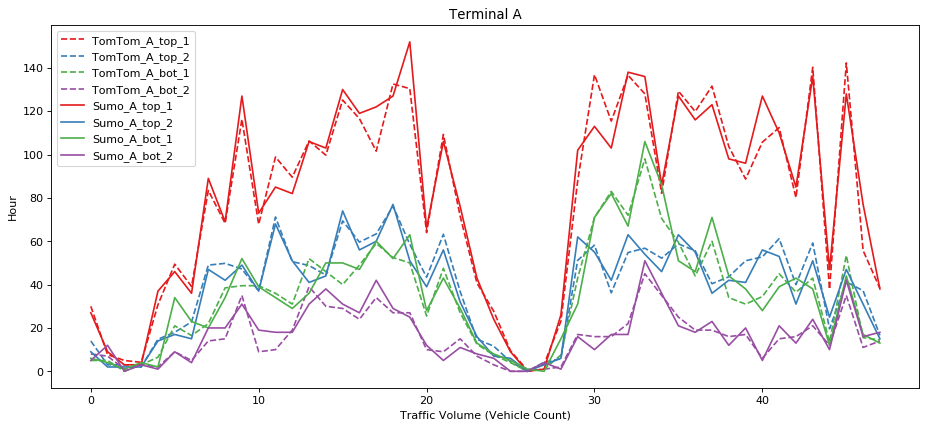

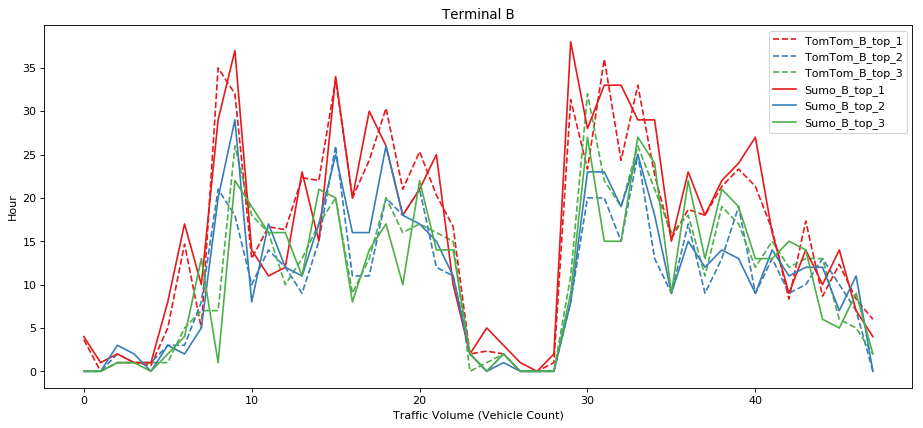

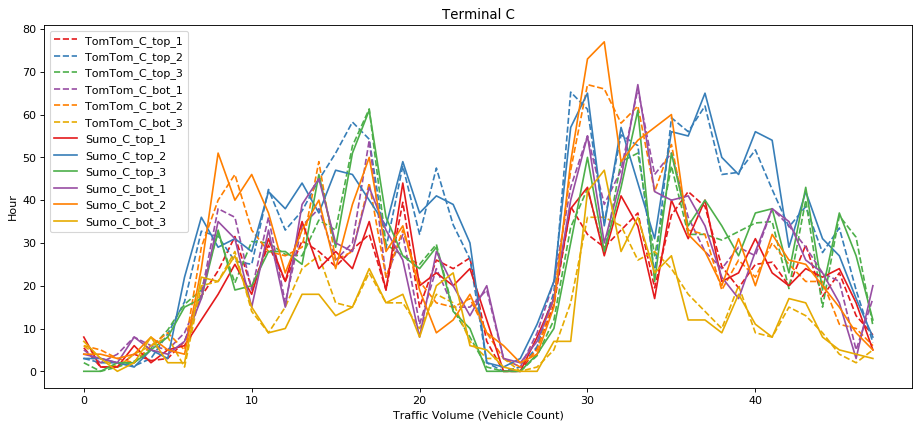

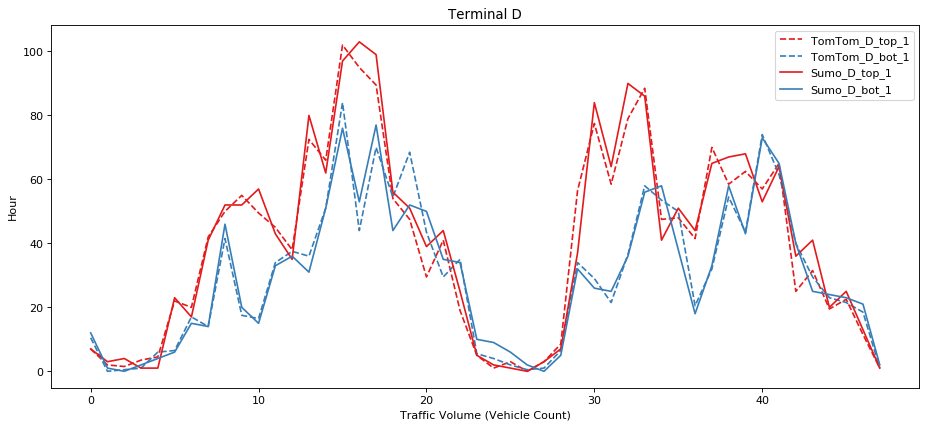

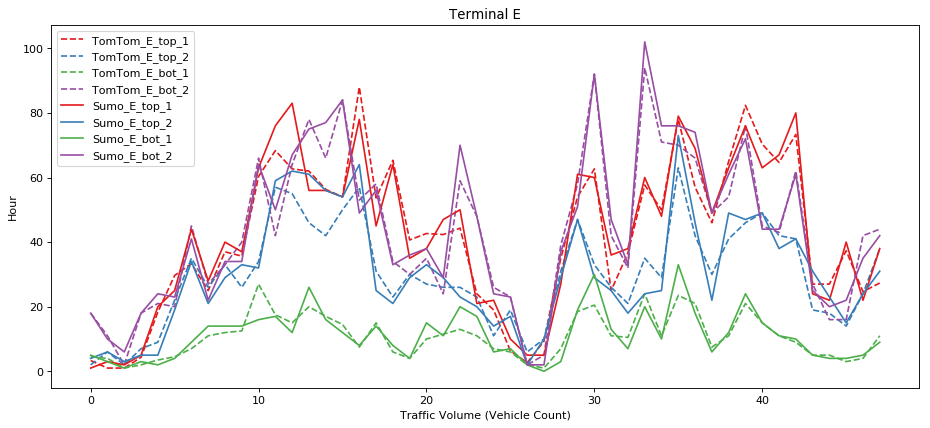

In [18]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import json

# This data comes from looking at the TomTom segments that correspond specifically
# to the named curb segments in Sumo.
terminals = ["A", "B", "C", "D", "E"]
colors = ["#e41a1c","#377eb8","#4daf4a","#984ea3","#ff7f00","#e6ab02"]
for i in range(5):
    figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    c = 0
    for edge, data in tomTomCurbData[terminals[i]].items():
        plt.plot(np.array(data[0:48]), label="TomTom_" + edge, linestyle="dashed", color=colors[c])
        c += 1
    c = 0
    for edge, data in curbSubscriptions[i].items():
        plt.plot(data["hourlyCounts"], label="Sumo_" + edge, color=colors[c])
        c += 1
    plt.title("Terminal " + terminals[i])
    plt.ylabel("Hour")
    plt.xlabel("Traffic Volume (Vehicle Count)")
    plt.legend()
    #plt.savefig("terminal_" + terminals[i] + ".png", dpi=300, bbox_inches="tight")
    plt.show()